# Automated ML

Import Dependencies. 

In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.interpret import ExplanationClient

## Dataset

### Overview

Dataset from Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone". BMC Medical Informatics and Decision Making 20, 16 (2020)

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

12 clinical features:

Thirteen (13) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

For this task, Azure auto machine learning will be performed to make accurate prediction on the death event based on patient's 12 clinical features. 

Review the Dataset Result

In [3]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-classification-experiment'

experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,de47103e-2da6-4f5e-88fc-d18b27fd249b
Workspace,quick-starts-ws-129489
Resource Group,aml-quickstarts-129489
Location,southcentralus
Experiment Name,automl-classification-experiment


In [5]:
# Try to load the dataset from the Workspace. Otherwise, create it from the file
# NOTE: update the key to match the dataset name
found = False
key = "heart-failure"
description_text = "Heart Failure DataSet for Predicting Death Event"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

if not found:
        # Create AML Dataset and register it into Workspace
        example_data = 'https://mlstrg129489.blob.core.windows.net/azureml-blobstore-c4204f9b-3fca-4d7a-9d5b-f08f17f1fd10'
        dataset = Dataset.Tabular.from_delimited_files(example_data)        
        #Register Dataset in Workspace
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description=description_text)


df = dataset.to_pandas_dataframe()
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
dataset.take(5).to_pandas_dataframe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Create or Attach an AmlCompute cluster

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D12_V2',
                                                           max_nodes=5)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [23]:
project_folder = './automl-project'

automl_settings = {
    "experiment_timeout_minutes": 30,
    "max_concurrent_iterations": 5,
    "primary_metric" : 'AUC_weighted'
}
automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "classification",
                             training_data=dataset,
                             label_column_name="DEATH_EVENT", 
                             enable_onnx_compatible_models=True,
                             path = project_folder,
                             enable_early_stopping= True,
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )

In [24]:
remote_run = experiment.submit(automl_config, show_output = True)

Running on remote.
Running on remote compute: cpu-cluster
Parent Run ID: AutoML_82495049-1153-41f2-900c-0f889bf9edf0

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Cross validation
STATUS:       DONE
DESCRIPTION:  Each iteration of the trained model was validated through cross-validation.
              
DETAILS:      
+---------------------------------+
|Number of folds                  |
+=================================+
|10                               |
+---------------------------------+

****************************************************************************************************

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn mo

In [29]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-experiment,AutoML_82495049-1153-41f2-900c-0f889bf9edf0,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [30]:
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment=experiment, run_id='AutoML_b580a705-20af-4f6c-a516-3aaede13be37')
#remote_run

In [31]:
# Wait for the remote run to complete
remote_run.wait_for_completion()

{'runId': 'AutoML_82495049-1153-41f2-900c-0f889bf9edf0',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-12-06T18:42:22.957908Z',
 'endTimeUtc': '2020-12-06T19:12:16.137056Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-classification-experiment","subscription_id":"de47103e-2da6-4f5e-88fc-d18b27fd249b","resource_group":"aml-quickstarts-129489","workspace_name":"quick-starts-ws-129489","region":"southcentralus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"AUC_weighted","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_valid

In [32]:
best_run_customized, fitted_model_customized = remote_run.get_output()

Transparency

View updated featurization summary

In [33]:
custom_featurizer = fitted_model_customized.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary()
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,age,Numeric,No,1,[MeanImputer]
1,anaemia,Numeric,No,1,[MeanImputer]
2,creatinine_phosphokinase,Numeric,No,1,[MeanImputer]
3,diabetes,Numeric,No,1,[MeanImputer]
4,ejection_fraction,Numeric,No,1,[MeanImputer]
5,high_blood_pressure,Numeric,No,1,[MeanImputer]
6,platelets,Numeric,No,1,[MeanImputer]
7,serum_creatinine,Numeric,No,1,[MeanImputer]
8,serum_sodium,Numeric,No,1,[MeanImputer]
9,sex,Numeric,No,1,[MeanImputer]


In [34]:
df = custom_featurizer.get_featurization_summary(is_user_friendly=False)
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,age,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['age'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
1,anaemia,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['anaemia'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
2,creatinine_phosphokinase,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['creatinine_phosphokinase'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
3,diabetes,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['diabetes'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
4,ejection_fraction,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['ejection_fraction'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
5,high_blood_pressure,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['high_blood_pressure'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
6,platelets,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['platelets'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
7,serum_creatinine,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['serum_creatinine'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
8,serum_sodium,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['serum_sodium'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"
9,sex,Numeric,No,1,[MeanImputer],"{'Transformer1': {'Input': ['sex'], 'TransformationFunction': 'Imputer', 'Operator': 'Mean', 'FeatureType': 'Numeric', 'ShouldOutput': True, 'TransformationParams': {'add_indicator': False, 'copy': True, 'fill_value': None, 'missing_values': nan, 'strategy': 'mean', 'verbose': 0}}}"


In [35]:

df = custom_featurizer.get_stats_feature_type_summary()
pd.DataFrame(data=df)

""


Results

In [36]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

Retrieve the Best Model's explanation

Retrieve the explanation from the best_run which includes explanations for engineered features and raw features. Make sure that the run for generating explanations for the best model is completed

In [37]:
# Wait for the best model explanation run to complete
from azureml.core.run import Run
model_explainability_run_id = remote_run.id + "_" + "ModelExplain"
print(model_explainability_run_id)
model_explainability_run = Run(experiment=experiment, run_id=model_explainability_run_id)
model_explainability_run.wait_for_completion()

# Get the best run object
best_run, fitted_model = remote_run.get_output()

AutoML_82495049-1153-41f2-900c-0f889bf9edf0_ModelExplain


Download engineered feature importance from artifact store

In [38]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'time_MeanImputer': 0.6828615681700457,
 'serum_creatinine_MeanImputer': 0.280339955499608,
 'ejection_fraction_MeanImputer': 0.2638657311443712,
 'age_MeanImputer': 0.14121409558457668,
 'serum_sodium_MeanImputer': 0.10508925237876746,
 'creatinine_phosphokinase_MeanImputer': 0.060346871724294975,
 'platelets_MeanImputer': 0.04068609469956441,
 'anaemia_MeanImputer': 0.014647517696200906,
 'sex_MeanImputer': 0.01389723788203218,
 'smoking_MeanImputer': 0.006978476662578424,
 'diabetes_MeanImputer': 0.004779288577221456,
 'high_blood_pressure_MeanImputer': 0.004420674332827049}

Download raw feature importance from artifact store

In [39]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'time': 0.6828615681700457,
 'serum_creatinine': 0.280339955499608,
 'ejection_fraction': 0.2638657311443712,
 'age': 0.14121409558457668,
 'serum_sodium': 0.10508925237876746,
 'creatinine_phosphokinase': 0.060346871724294975,
 'platelets': 0.04068609469956441,
 'anaemia': 0.014647517696200906,
 'sex': 0.01389723788203218,
 'smoking': 0.006978476662578424,
 'diabetes': 0.004779288577221456,
 'high_blood_pressure': 0.004420674332827049}

## Retrieve the Best ONNX Mode

Below we select the best pipeline from our iterations. The get_output method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

Set the parameter return_onnx_model=True to retrieve the best ONNX model, instead of the Python model.

In [40]:
best_run, onnx_mdl = remote_run.get_output(return_onnx_model=True)

## Save the best ONNX model

In [41]:
from azureml.automl.runtime.onnx_convert import OnnxConverter
onnx_fl_path = "./best_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

## Predict with the ONNX model, using onnxruntime package

In [44]:
df_test = dataset.to_pandas_dataframe()
df_test = df_test[pd.notnull(df_test['DEATH_EVENT'])]

y_test = df_test['DEATH_EVENT']
X_test = df_test.drop(['DEATH_EVENT'], axis=1)

In [54]:
df_test

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.00,0,582,0,20,1,265000.00,1.90,130,1,0,4,1
1,55.00,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1
2,65.00,0,146,0,20,0,162000.00,1.30,129,1,1,7,1
3,50.00,1,111,0,20,0,210000.00,1.90,137,1,0,7,1
4,65.00,1,160,1,20,0,327000.00,2.70,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.00,0,61,1,38,1,155000.00,1.10,143,1,1,270,0
295,55.00,0,1820,0,38,0,270000.00,1.20,139,0,0,271,0
296,45.00,0,2060,1,60,0,742000.00,0.80,138,0,0,278,0
297,45.00,0,2413,0,38,0,140000.00,1.40,140,1,1,280,0


In [47]:
import sys
import json
from azureml.automl.core.onnx_convert import OnnxConvertConstants
from azureml.train.automl import constants

if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    python_version_compatible = True
else:
    python_version_compatible = False

import onnxruntime
from azureml.automl.runtime.onnx_convert import OnnxInferenceHelper

def get_onnx_res(run):
    res_path = 'onnx_resource.json'
    run.download_file(name=constants.MODEL_RESOURCE_PATH_ONNX, output_file_path=res_path)
    with open(res_path) as f:
        onnx_res = json.load(f)
    return onnx_res

if python_version_compatible:
    test_df = X_test
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_res = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_res)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(test_df)

    print(pred_onnx)
    print(pred_prob_onnx)
else:
    print('Please use Python version 3.6 or 3.7 to run the inference helper.')

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0
 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[[0.15625685 0.84374315]
 [0.4072705  0.5927295 ]
 [0.20921719 0.7907828 ]
 [0.24292453 0.75707555]
 [0.18315658 0.8168435 ]
 [0.21501546 0.7849846 ]
 [0.20251253 0.79748744]
 [0.3677776  0.6322224 ]
 [0.36442548 0.6355745 ]
 [0.19752175 0.8024782 ]
 [0.22597113 0.7740289 ]
 [0.3347662  0.6652338 ]
 [0.37104836 0.62895167]
 [0.43642125 0.5635788 ]
 [0.47332034 0.5266797 ]
 [0.28070453 0.71

## Deploy

Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method returns the best run and the fitted model. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

Widget for Monitoring Runs
The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

Note: The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [48]:
best_run, fitted_model = remote_run.get_output()

In [49]:
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')

## Register the Fitted Model for Deployment

In [51]:
description = 'AutoML Model trained on bank marketing data to predict if a client will subscribe to a term deposit'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id) # This will be written to the script file later in the notebook

AutoML82495049157


## Deploy the model as a Web Service on Azure Container Instance

In [52]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

inference_config = InferenceConfig(entry_script=script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "bmData", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

aci_service_name = 'automl-heart-failure'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-heart-failure
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


## Get Logs from a Deployed Web Service

In [53]:
aci_service.get_logs()

'2020-12-06T19:33:57,024074476+00:00 - gunicorn/run \n2020-12-06T19:33:57,024073676+00:00 - iot-server/run \n2020-12-06T19:33:57,025591045+00:00 - rsyslog/run \n2020-12-06T19:33:57,070430175+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_7cf2b5eebfc9a832d561ce064cfbc38b/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

## Test

Now that the model is trained, run the test data through the trained model to get the predicted values. This calls the ACI web service to do the prediction.

Note that the JSON passed to the ACI web service is an array of rows of data. Each row should either be an array of values in the same order that was used for training or a dictionary where the keys are the same as the column names used for training. The example below uses dictionary rows.

In [55]:
from numpy import array

X_test = dataset.drop_columns(columns=['DEATH_EVENT'])
y_test = dataset.keep_columns(columns=['DEATH_EVENT'], validate=True)
dataset.take(5).to_pandas_dataframe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.00,0,582,0,20,1,265000.00,1.90,130,1,0,4,1
1,55.00,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1
2,65.00,0,146,0,20,0,162000.00,1.30,129,1,1,7,1
3,50.00,1,111,0,20,0,210000.00,1.90,137,1,0,7,1
4,65.00,1,160,1,20,0,327000.00,2.70,116,0,0,8,1


In [56]:

X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [57]:
import json
import requests

X_test_json = X_test.to_json(orient='records')
data = "{\"data\": " + X_test_json +"}"
headers = {'Content-Type': 'application/json'}

resp = requests.post(aci_service.scoring_uri, data, headers=headers)

y_pred = json.loads(json.loads(resp.text))['result']

In [58]:

actual = array(y_test)
actual = actual[:,0]
print(len(y_pred), " ", len(actual))

299   299


## Calculate metrics for the prediction

Now visualize the data as a confusion matrix that compared the predicted values against the actual values.

<IPython.core.display.Javascript object>


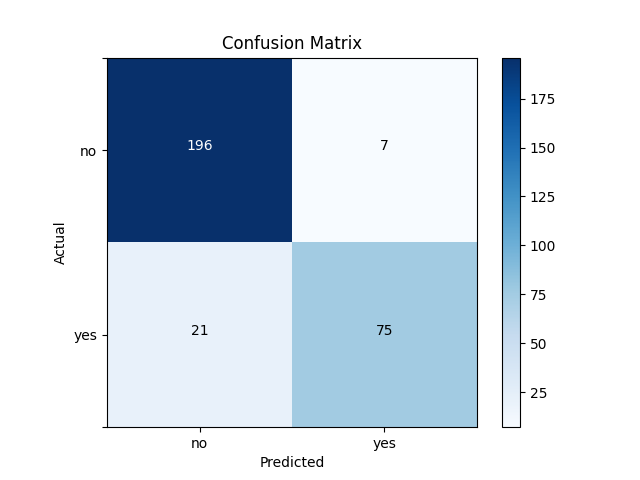

In [59]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(actual,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['no','yes']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','no','yes',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## Delete a Web Service

In [60]:
aci_service.delete()

Create Pipeline and AutoMLStep

In [16]:
from azureml.pipeline.core import PipelineData, TrainingOutput

ds = ws.get_default_datastore()
metrics_output_name = 'metrics_output'
best_model_output_name = 'best_model_output'

metrics_data = PipelineData(name='metrics_data',
                           datastore=ds,
                           pipeline_output_name=metrics_output_name,
                           training_output=TrainingOutput(type='Metrics'))
model_data = PipelineData(name='model_data',
                           datastore=ds,
                           pipeline_output_name=best_model_output_name,
                           training_output=TrainingOutput(type='Model'))

In [18]:
from azureml.pipeline.steps import AutoMLStep

automl_step = AutoMLStep(
    name='automl_module',
    automl_config=automl_config,
    outputs=[metrics_data, model_data],
    allow_reuse=True)

In [19]:
from azureml.pipeline.core import Pipeline

pipeline = Pipeline(
    description="pipeline_with_automlstep",
    workspace=ws,    
    steps=[automl_step])

In [20]:
# Submit your experiment
remote_run = experiment.submit(pipeline)

Created step automl_module [0c33b2f3][b3fb1218-cd65-471c-b6e0-0f88fcb949de], (This step will run and generate new outputs)
Submitted PipelineRun 68cc18ea-a11c-46bc-902e-21ecbf0165bf
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/automl-classification-experiment/runs/68cc18ea-a11c-46bc-902e-21ecbf0165bf?wsid=/subscriptions/de47103e-2da6-4f5e-88fc-d18b27fd249b/resourcegroups/aml-quickstarts-129489/workspaces/quick-starts-ws-129489


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [21]:
from azureml.widgets import RunDetails

RunDetails(remote_run).show()

_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

In [22]:
remote_run.wait_for_completion()

PipelineRunId: 68cc18ea-a11c-46bc-902e-21ecbf0165bf
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/automl-classification-experiment/runs/68cc18ea-a11c-46bc-902e-21ecbf0165bf?wsid=/subscriptions/de47103e-2da6-4f5e-88fc-d18b27fd249b/resourcegroups/aml-quickstarts-129489/workspaces/quick-starts-ws-129489
PipelineRun Status: Running


StepRunId: cdce0dee-697d-4c4d-9c71-75aab5dc430f
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/automl-classification-experiment/runs/cdce0dee-697d-4c4d-9c71-75aab5dc430f?wsid=/subscriptions/de47103e-2da6-4f5e-88fc-d18b27fd249b/resourcegroups/aml-quickstarts-129489/workspaces/quick-starts-ws-129489
StepRun( automl_module ) Status: Running

StepRun(automl_module) Execution Summary
StepRun( automl_module ) Status: Finished
{'runId': 'cdce0dee-697d-4c4d-9c71-75aab5dc430f', 'target': 'cpu-cluster', 'status': 'Completed', 'startTimeUtc': '2020-12-06T16:16:01.001563Z', 'endTimeUtc': '2020-12-06T16:57:28.839987Z', 'pr

'Finished'

Retrieve the metrics of all child runs

In [23]:
metrics_output = remote_run.get_pipeline_output(metrics_output_name)
num_file_downloaded = metrics_output.download('.', show_progress=True)

Downloaded azureml/cdce0dee-697d-4c4d-9c71-75aab5dc430f/metrics_data, 1 files out of an estimated total of 1


In [24]:
import json
with open(metrics_output._path_on_datastore) as f:
    metrics_output_result = f.read()
    
deserialized_metrics_output = json.loads(metrics_output_result)
df = pd.DataFrame(deserialized_metrics_output)
df

,cdce0dee-697d-4c4d-9c71-75aab5dc430f_9,cdce0dee-697d-4c4d-9c71-75aab5dc430f_11,cdce0dee-697d-4c4d-9c71-75aab5dc430f_15,cdce0dee-697d-4c4d-9c71-75aab5dc430f_17,cdce0dee-697d-4c4d-9c71-75aab5dc430f_35,cdce0dee-697d-4c4d-9c71-75aab5dc430f_33,cdce0dee-697d-4c4d-9c71-75aab5dc430f_40,cdce0dee-697d-4c4d-9c71-75aab5dc430f_31,cdce0dee-697d-4c4d-9c71-75aab5dc430f_38,cdce0dee-697d-4c4d-9c71-75aab5dc430f_48,...,cdce0dee-697d-4c4d-9c71-75aab5dc430f_27,cdce0dee-697d-4c4d-9c71-75aab5dc430f_2,cdce0dee-697d-4c4d-9c71-75aab5dc430f_25,cdce0dee-697d-4c4d-9c71-75aab5dc430f_16,cdce0dee-697d-4c4d-9c71-75aab5dc430f_26,cdce0dee-697d-4c4d-9c71-75aab5dc430f_37,cdce0dee-697d-4c4d-9c71-75aab5dc430f_39,cdce0dee-697d-4c4d-9c71-75aab5dc430f_43,cdce0dee-697d-4c4d-9c71-75aab5dc430f_4,cdce0dee-697d-4c4d-9c71-75aab5dc430f_57
accuracy,[0.8293103448275861],[0.825977011494253],[0.7857471264367817],[0.8126436781609195],[0.7859770114942528],[0.8394252873563219],[0.785632183908046],[0.7956321839080459],[0.8393103448275863],[0.7388505747126436],...,[0.8560919540229885],[0.7458620689655173],[0.7390804597701149],[0.8193103448275864],[0.6721839080459768],[0.8394252873563219],[0.8127586206896552],[0.8428735632183908],[0.7588505747126437],[0.859425287356322]
f1_score_micro,[0.8293103448275861],[0.825977011494253],[0.7857471264367817],[0.8126436781609195],[0.7859770114942528],[0.8394252873563219],[0.785632183908046],[0.7956321839080459],[0.8393103448275863],[0.7388505747126436],...,[0.8560919540229885],[0.7458620689655173],[0.7390804597701149],[0.8193103448275864],[0.6721839080459768],[0.8394252873563219],[0.8127586206896552],[0.8428735632183908],[0.7588505747126437],[0.859425287356322]
recall_score_macro,[0.7759512575630997],[0.7733196786157313],[0.7015439609123819],[0.7462175862636389],[0.676686422495633],[0.7789554410014936],[0.758654467608415],[0.767995737449685],[0.7932495727956255],[0.6066813466747677],...,[0.8029453399913926],[0.6557719298245613],[0.5875308188400293],[0.7547132667527404],[0.49409722222222224],[0.797718522948786],[0.7390401572112097],[0.7822142192602719],[0.7527046910204805],[0.8059696305156832]
AUC_micro,[0.8850002642356983],[0.8886669309023649],[0.8724798520280089],[0.9097273087594134],[0.8795558197912537],[0.9156064209274672],[0.864125115603118],[0.8681582771832475],[0.9170450521865504],[0.844975029726516],...,[0.913608402695204],[0.7949458316818602],[0.8535481569560048],[0.8887604703395429],[0.7010648698639186],[0.9079417360285374],[0.8988306249174263],[0.9164543532831285],[0.854378649755582],[0.9162419077817413]
recall_score_weighted,[0.8293103448275861],[0.825977011494253],[0.7857471264367817],[0.8126436781609195],[0.7859770114942528],[0.8394252873563219],[0.785632183908046],[0.7956321839080459],[0.8393103448275863],[0.7388505747126436],...,[0.8560919540229885],[0.7458620689655173],[0.7390804597701149],[0.8193103448275864],[0.6721839080459768],[0.8394252873563219],[0.8127586206896552],[0.8428735632183908],[0.7588505747126437],[0.859425287356322]
average_precision_score_macro,[0.8408176022751933],[0.8442785435980411],[0.8588125535438467],[0.8763540169188715],[0.8664276249967262],[0.8896414545605087],[0.8408425852855984],[0.8440240038604149],[0.8914864610254991],[0.8462782282515118],...,[0.8859118412639401],[0.745969560448301],[0.8485225172575511],[0.8427959460987688],[0.6042391280286348],[0.8773852189980126],[0.8791389755624831],[0.8962156877589521],[0.8493847317247164],[0.902584211847906]
norm_macro_recall,[0.5519025151261994],[0.5466393572314625],[0.40708792182476394],[0.49243517252727786],[0.35337284499126603],[0.5579108820029872],[0.5333089352168299],[0.5479914748993696],[0.5864991455912509],[0.21706639705323916],...,[0.6058906799827852],[0.3115438596491228],[0.18276534138376244],[0.5094265335054808],[0.0],[0.5954370458975722],[0.47808031442241966],[0.5644284385205438],[0.5094093820409611],[0.6119392610313662]
AUC_macro,[0.8510652707104462],[0.8564997525379106],[0.8482918721466968],[0.8902050418554805],[0.8745345710657114],[0.9009934773803195

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [25]:
best_model_output = remote_run.get_pipeline_output(best_model_output_name)
num_file_downloaded = best_model_output.download('.', show_progress=True)

Downloaded azureml/cdce0dee-697d-4c4d-9c71-75aab5dc430f/model_data, 1 files out of an estimated total of 1


In [26]:
import pickle

with open(best_model_output._path_on_datastore, "rb" ) as f:
    best_model = pickle.load(f)
best_model

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                  random_state=None,
                                                                                                  verbose=0,
                                                                                                  warm_start=False))],
                                               

In [29]:
best_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                                estimators=[('36',
                                             Pipeline(memory=None,
                                                      steps=[('minmaxscaler',
                                                              MinMaxScaler(copy=True,
                                                                           feature_range=(0,
                                                                                          1))),
                                                             ('lightgbmclassifier',
                                                              LightGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=0.1988888888888889,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.07894947368421053,
                                                                                 max_bin=70,
                                                                                 m...
                                                                                   oob_score=True,
                                                                                   random_state=None,
                                                                                   verbose=0,
                                                                                   warm_start=False))],
                                                      verbose=False))],
                                flatten_transform=None,
                                weights=[0.13333333333333333, 0.06666666666666667,
                                         0.06666666666666667, 0.06666666666666667,
                                         0.13333333333333333, 0.06666666666666667,
                                         0.06666666666666667, 0.06666666666666667,
                                         0.06666666666666667, 0.13333333333333333,
                                         0.06666666666666667,
                                         0.06666666666666667]))]

In [ ]:
#TODO: Save the best model

Test the Model

In [31]:
dataset_test = Dataset.Tabular.from_delimited_files(path='https://mlstrg129489.blob.core.windows.net/azureml-blobstore-c4204f9b-3fca-4d7a-9d5b-f08f17f1fd10')
df_test = dataset_test.to_pandas_dataframe()
df_test = df_test[pd.notnull(df_test['DEATH_EVENT'])]

y_test = df_test['DEATH_EVENT']
X_test = df_test.drop(['DEATH_EVENT'], axis=1)

DatasetValidationError: DatasetValidationError:
	Message: Cannot load any data from the specified path. Make sure the path is accessible and contains data.
ScriptExecutionException was caused by StreamAccessException.
  StreamAccessException was caused by AuthenticationException.
    Identity authentication failed for 'AzureBlob GetReference' operation at '[REDACTED]' with '403: AuthorizationPermissionMismatch'. Please make sure the compute or login identity has 'Storage Blob Data Reader' or 'Storage Blob Data Owner' role in the storage IAM.
      Failed due to inner exception of type: StorageException
| session_id=c05a52de-8f29-4bfb-9832-7a1480991b3d
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Cannot load any data from the specified path. Make sure the path is accessible and contains data.\nScriptExecutionException was caused by StreamAccessException.\n  StreamAccessException was caused by AuthenticationException.\n    Identity authentication failed for 'AzureBlob GetReference' operation at '[REDACTED]' with '403: AuthorizationPermissionMismatch'. Please make sure the compute or login identity has 'Storage Blob Data Reader' or 'Storage Blob Data Owner' role in the storage IAM.\n      Failed due to inner exception of type: StorageException\n| session_id=c05a52de-8f29-4bfb-9832-7a1480991b3d"
    }
}

Testing Our Best Fitted Model

In [32]:
from sklearn.metrics import confusion_matrix
ypred = best_model.predict(X_test)
cm = confusion_matrix(y_test, ypred)

NameError: name 'X_test' is not defined

In [33]:
# Visualize the confusion matrix
pd.DataFrame(cm).style.background_gradient(cmap='Blues', low=0, high=0.9)

NameError: name 'cm' is not defined

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

Publish and run from REST endpoint

In [38]:
published_pipeline = remote_run.publish_pipeline(
    name="Heart Failure Train", description="Training heart failure pipeline", version="1.0")

published_pipeline

Name,Id,Status,Endpoint
Heart Failure Train,780fc965-8135-453f-aae9-0af36591527a,Active,REST Endpoint


TODO: In the cell below, send a request to the web service you deployed to test it.

Authenticate once again, to retrieve the auth_header so that the endpoint can be used

In [39]:
from azureml.core.authentication import InteractiveLoginAuthentication

interactive_auth = InteractiveLoginAuthentication()
auth_header = interactive_auth.get_authentication_header()

TODO: In the cell below, print the logs of the web service and delete the service

Get the REST url from the endpoint property of the published pipeline object. Build an HTTP POST request to the endpoint, specifying your authentication header. Additionally, add a JSON payload object with the experiment name and the batch size parameter. 

Make the request to trigger the run. Access the Id key from the response dict to get the value of the run id.

In [40]:
import requests

rest_endpoint = published_pipeline.endpoint
response = requests.post(rest_endpoint, 
                         headers=auth_header, 
                         json={"ExperimentName": "pipeline-rest-endpoint"}
                        )

In [41]:
try:
    response.raise_for_status()
except Exception:    
    raise Exception("Received bad response from the endpoint: {}\n"
                    "Response Code: {}\n"
                    "Headers: {}\n"
                    "Content: {}".format(rest_endpoint, response.status_code, response.headers, response.content))

run_id = response.json().get('Id')
print('Submitted pipeline run: ', run_id)

Submitted pipeline run:  ccdf29a4-191d-4ec2-a35c-876df2aad6b7


In [42]:
from azureml.pipeline.core.run import PipelineRun
from azureml.widgets import RunDetails

published_pipeline_run = PipelineRun(ws.experiments["pipeline-rest-endpoint"], run_id)
RunDetails(published_pipeline_run).show()

_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

Retrieve the Best Model's explanation
Retrieve the explanation from the best_run which includes explanations for engineered features and raw features. Make sure that the run for generating explanations for the best model is completed.

AttributeError: 'PipelineRun' object has no attribute 'get_output'